# Analysis of Bracken data in R with phyloseq

1. Loading libraries and data
2. Creating a phyloseq object and making some changes for easier viewing

I am quite sure we won't get to much more than loading the data into R since we are trying to do all of this in one day - however, once you have the data in phyloseq, there are some great tutorials on what to do with it in the phyloseq documentation here: https://joey711.github.io/phyloseq/

The objective of this is to just get you started with loading data into phyloseq.

### Loading libraries and data

We'll load three packages here: 

1. tidyverse, which is kind of a meta-package for doing simplified operations to dataframes in R
2. vegan, a foundational package for doing a lot of statistical operations common in ecology, which is widely used for microbial ecology as well.
3. [Phyloseq](https://joey711.github.io/phyloseq/), an R package designed specifically for visualizing and analyzing microbial community data. Every operation that phyloseq does can also be done outside the phyloseq package, but it's a very handy tool to use, particularly if you're newer to R, and extremely well-documented with lots of nice tutorials.

In [2]:
library(phyloseq)
library(vegan)
library(tidyverse)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.3     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.3
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Now let's load the data we saved using the kraken-biom script. First we'll get the path to the biom file into a variable:

In [1]:
biomfilename <- "Zymo_16S_table.biom"

And then import the biom file into phyloseq using the phyloseq command "import_biom"

In [3]:
data <- import_biom(biomfilename, parseFunction=parse_taxonomy_default)

Let's look at the phyloseq object that we have called "data"

In [4]:
data

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3160 taxa and 2 samples ]
tax_table()   Taxonomy Table:    [ 3160 taxa by 7 taxonomic ranks ]

The OTU table contains the counts for each species for each sample. Run the command below to view 6 lines from the table. The 'head' command lets you view the top n lines of an R object; the default number of lines is 6.

In [5]:
head(otu_table(data))

,unfiltered,filtered
72360,14907,375
260554,2765,112
1390,1731,37
659243,680,6
492670,124,1
1423,2597,44


In [6]:
head(tax_table(data))

,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7
72360,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__mojavensis
260554,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__halotolerans
1390,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__amyloliquefaciens
659243,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__siamensis
492670,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__velezensis
1423,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__subtilis


The OTU table contains the counts of each species detected in each of the samples (the same dataset with filtering and without filtering)

I find it very annoying to have the taxa (rows/species) defined by numbers instead of the species names. The code below renames the taxa using the species names. No need to understand it right at this moment!

In [7]:
temp_taxa_w_names <- data.frame(tax_table(data)) %>%
    select(Rank6, Rank7) %>%
    mutate(Rank6=str_remove(Rank6, "g__")) %>%
    mutate(Rank7=str_remove(Rank7, "s__")) %>%
    mutate(taxa=paste(Rank6, Rank7))
taxa_names(data) <- temp_taxa_w_names$taxa

In [8]:
colnames(tax_table(data)) <- c("Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species")

In [9]:
head(tax_table(data))

,Domain,Phylum,Class,Order,Family,Genus,Species
Bacillus mojavensis,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__mojavensis
Bacillus halotolerans,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__halotolerans
Bacillus amyloliquefaciens,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__amyloliquefaciens
Bacillus siamensis,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__siamensis
Bacillus velezensis,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__velezensis
Bacillus subtilis,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Bacillus,s__subtilis


In [10]:
head(otu_table(data))

,unfiltered,filtered
Bacillus mojavensis,14907,375
Bacillus halotolerans,2765,112
Bacillus amyloliquefaciens,1731,37
Bacillus siamensis,680,6
Bacillus velezensis,124,1
Bacillus subtilis,2597,44


How many species in our dataset?

In [11]:
ntaxa(data)

[1] 3160

What are our samples?

In [12]:
sample_names(data)

[1] "unfiltered" "filtered"

Now, we are going to normalize the data by number of reads - this can be done in a variety of ways. The most common way is to convert each column into percentages (number of reads). This is a contentious subject.

In [13]:
sum(otu_table(data))

[1] 487383

In [22]:
data_norm=transform_sample_counts(data, function(OTU) OTU/sum(OTU) )

In [16]:
data_filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1077 taxa and 2 samples ]
tax_table()   Taxonomy Table:    [ 1077 taxa by 7 taxonomic ranks ]

This sequencing data is from a mock microbial community from Zymo, and has known species in it. Since the 16S gene was amplified, only the bacterial species in it would be detected. I've included a spreadsheet with the relative percentages and species we SHOULD detect, in a perfect world. We should only be detecting 8 taxa...but we've detected over one thousand! So, the process is imperfect.

In [18]:
zymo_std_bac <- read.csv("zymo_standard_bacteriaonly.csv")
zymo_std_bac

Species,Percentage
<chr>,<dbl>
Listeria monocytogenes,12.5
Pseudomonas aeruginosa,12.5
Bacillus subtilis,12.5
Escherichia coli,12.5
Salmonella enterica,12.5
Lactobacillus fermentum,12.5
Enterococcus faecalis,12.5
Staphylococcus aureus,12.5


Let's just take a quick look at differences in alpha diversity - i.e. what is the diversity of each individual sample. We can see right away....there are a lot more species observed in the unfiltered data vs the filtered data!

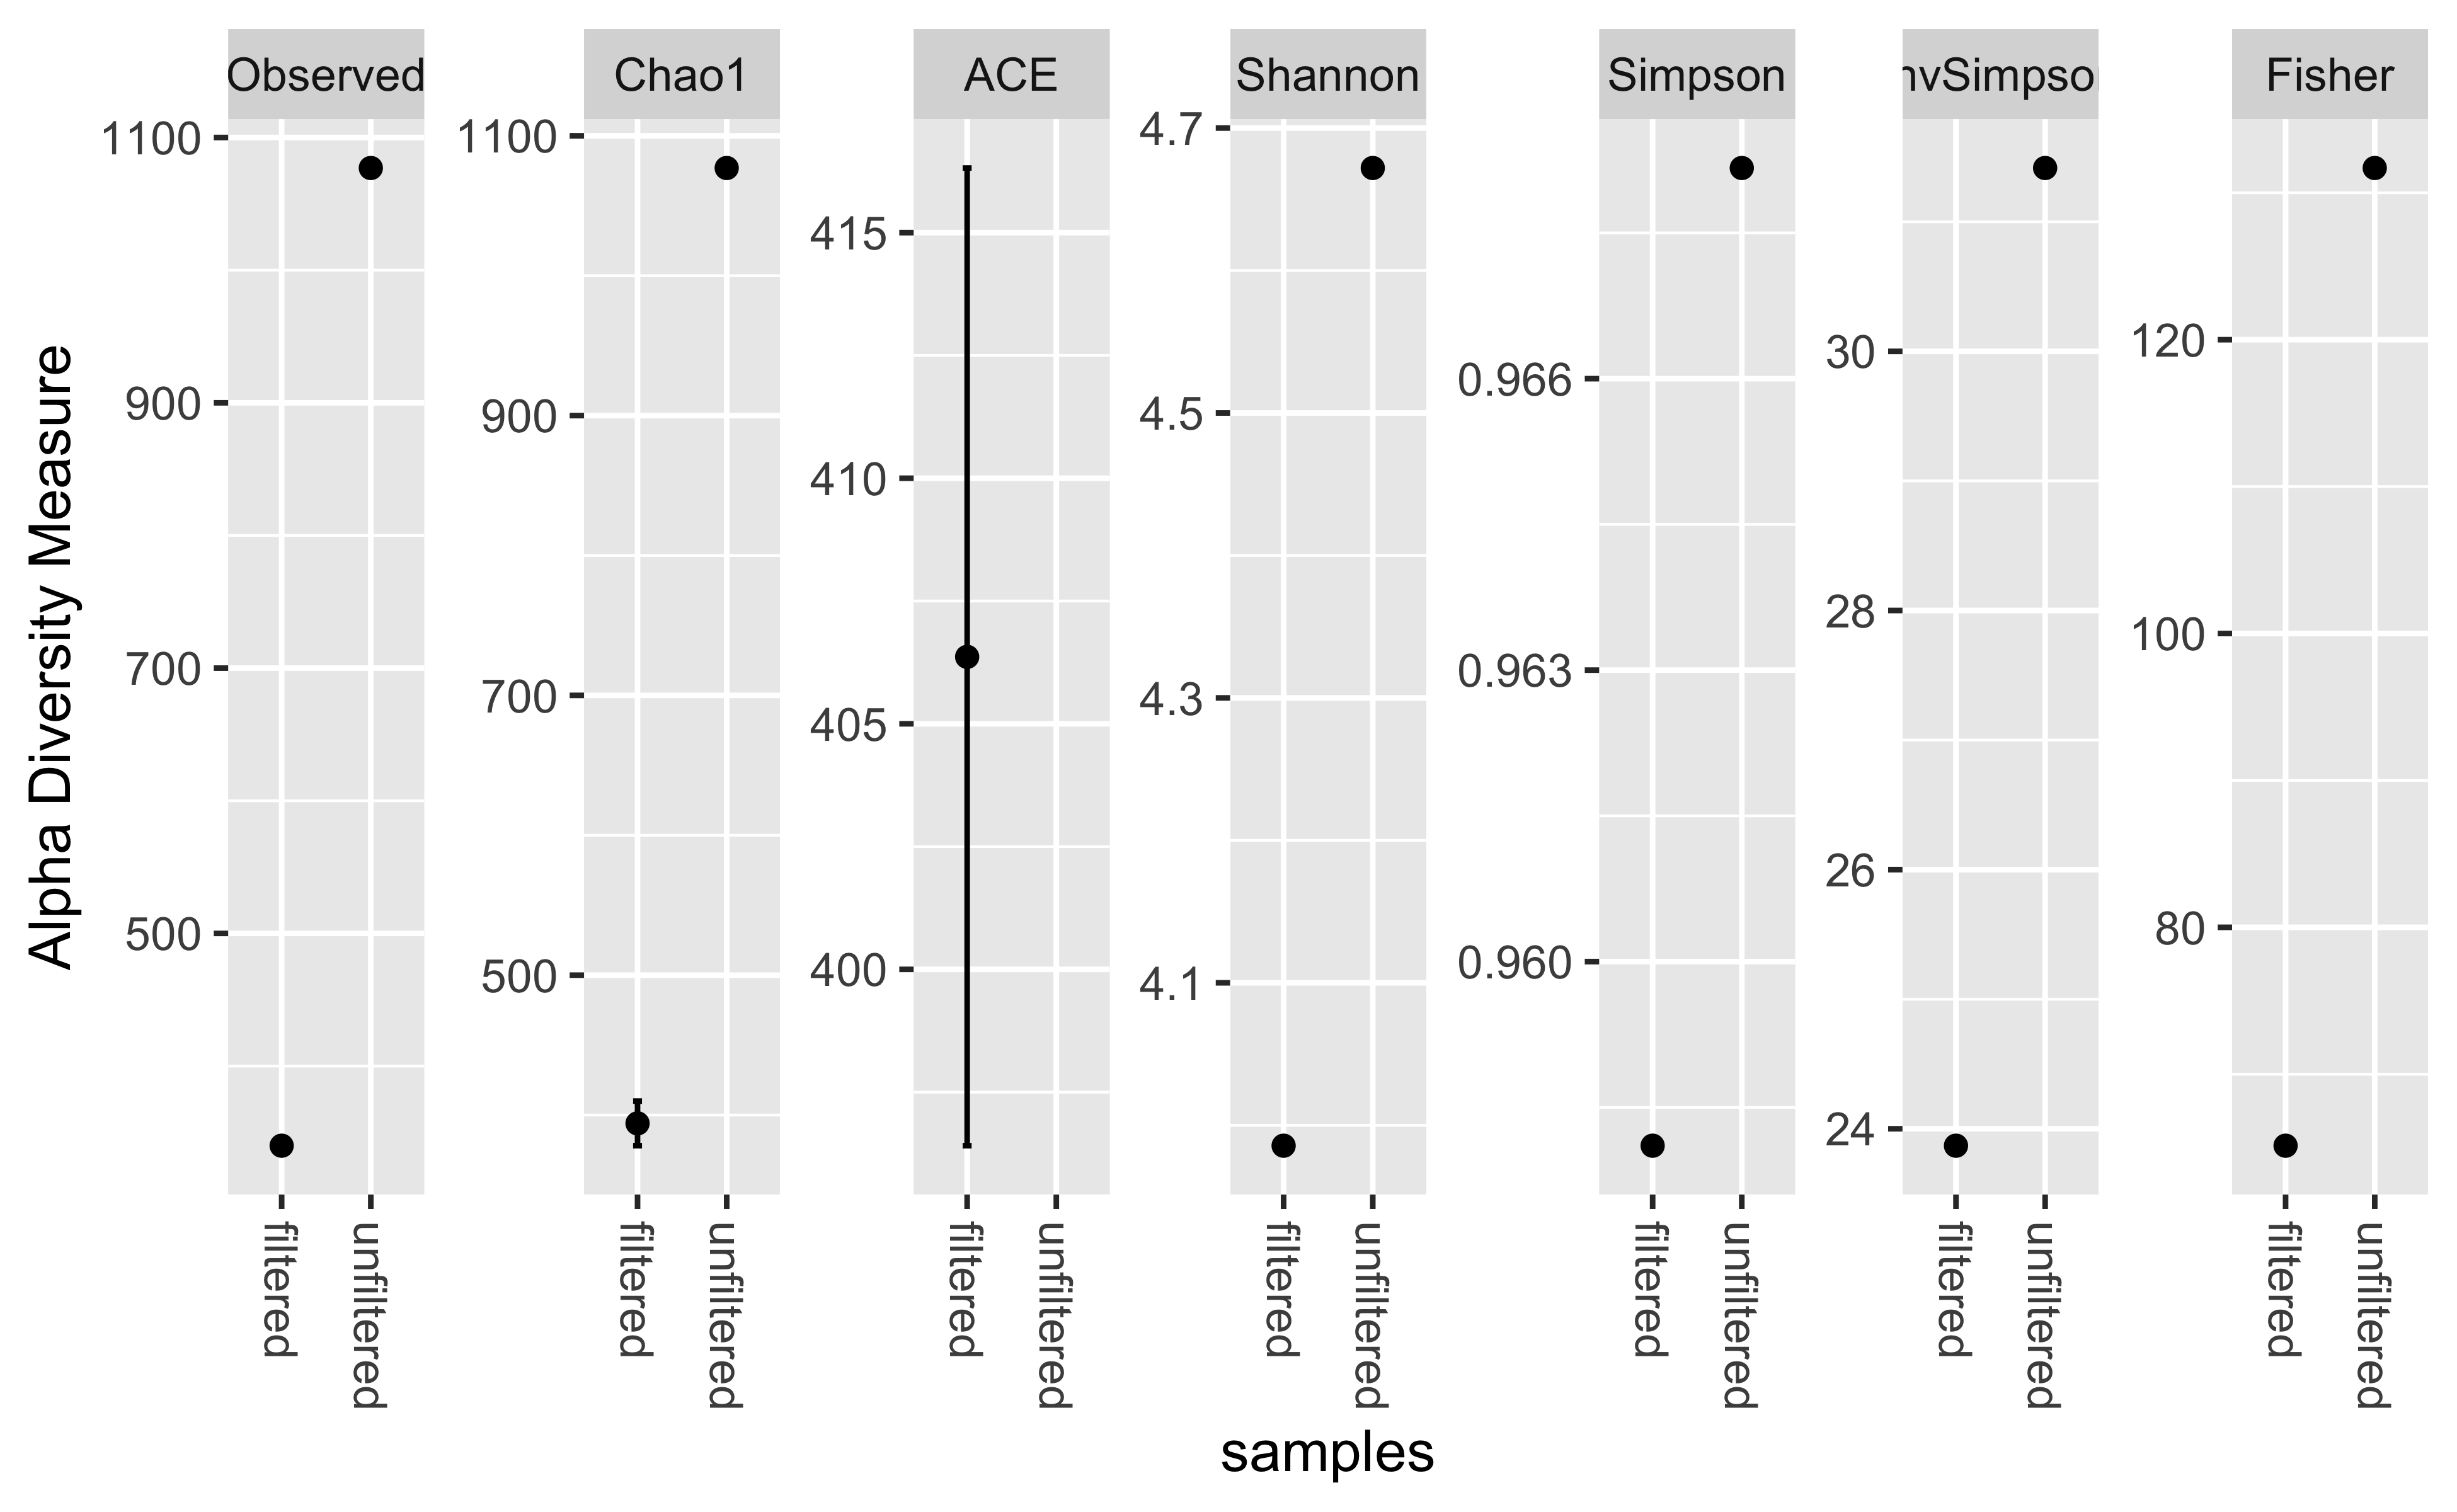

In [19]:
options(repr.plot.width=6.5, repr.plot.height=4, repr.plot.res = 600)
plot_richness(data_filt)

In [23]:
new_otu_table <- data.frame(otu_table(data_norm)) %>%
    rownames_to_column("Species") %>%
    left_join(zymo_std_bac) %>% 
    replace(is.na(.), 0) %>%
    column_to_rownames("Species")
otumat <- as.matrix(new_otu_table)

Joining with `by = join_by(Species)`


In [26]:
data_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3160 taxa and 2 samples ]
tax_table()   Taxonomy Table:    [ 3160 taxa by 7 taxonomic ranks ]

In [24]:
taxmat <- as.matrix(tax_table(data_norm))